In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from cv2 import imread
from math import sqrt,exp


import torch
import torch.nn.functional as F


In [2]:
rel_path = '../images/'
images_list = [rel_path + p for p in os.listdir(rel_path)]
images_list[0]

'../images/LBC30-20210102(1)_406.png'

In [3]:
def distance(point1,point2):
    return sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def idealFilterLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),center) < D0:
                base[y,x] = 1
    return base

def idealFilterHP(D0,imgShape):
    base = np.ones(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),center) < D0:
                base[y,x] = 0
    return base

def butterworthLP(D0,imgShape,n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = 1/(1+(distance((y,x),center)/D0)**(2*n))
    return base

def butterworthHP(D0,imgShape,n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = 1-1/(1+(distance((y,x),center)/D0)**(2*n))
    return base

def gaussianLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

def gaussianHP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = 1 - exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = list(map(int, bbox))
#     print(bbox)
#     x_min, y_min, x_max, y_max = list(map(round, bbox))
#     print((int(x_min), int(y_min)), (int(x_max), int(y_max)))

    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color=BOX_COLOR, thickness=thickness)
    return img

def visualize(image, bboxes):
    img = image.copy()
    print(img.shape)
#     img = image.clone().detach()
    for bbox in (bboxes):
#         print(bbox)
        img = visualize_bbox(img, bbox)
    plt.figure(figsize=(7, 7))
    plt.axis('off')
    plt.imshow(img)

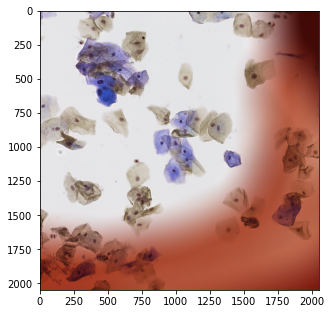

In [5]:
IMAGE_NUM = 2
img = cv2.imread(images_list[IMAGE_NUM])
#img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(5, 10))
plt.imshow(img);

In [82]:
# IMAGE_NUM = 2
# img = cv2.imread(images_list[IMAGE_NUM])
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# gray = cv2.resize(img, (512,512))
# gray_bin = gray < 200
# plt.figure(figsize=(5, 10))
# plt.imshow(gray_bin);


In [74]:
# img = cv2.imread(images_list[IMAGE_NUM])
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = cv2.resize(img, (512,512))
# original = np.fft.fft2(img)
# center = np.fft.fftshift(original)
# MidPassCenter = center * gaussianLP(15,img.shape) * gaussianHP(10,img.shape)
# MidPass = np.fft.ifftshift(MidPassCenter)
# inverse_MidPass = np.fft.ifft2(MidPass)
# MidPass_bin = np.abs(inverse_MidPass) > 5
# plt.figure(figsize=(5, 10))
# plt.imshow(MidPass_bin);
# print(MidPass_bin.shape)

(512, 512)


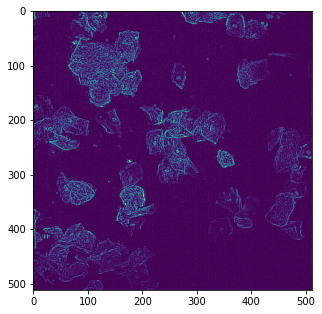

In [16]:
IMAGE_NUM = 2
img = cv2.imread(images_list[IMAGE_NUM])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(img, (512,512))
laplacian = cv2.Laplacian(gray,cv2.CV_8U,ksize=3)
th3 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,15,2)

plt.figure(figsize=(5, 10))
plt.imshow(laplacian);
# plt.imshow(th3);
print(laplacian.shape)

In [25]:
# laplacian

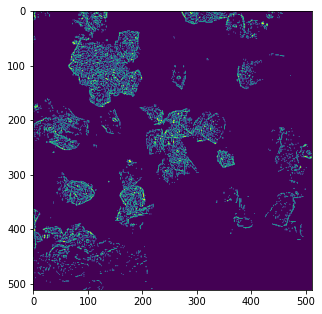

In [36]:
plt.figure(figsize=(5, 10))
plt.imshow((laplacian > 70).astype(float));


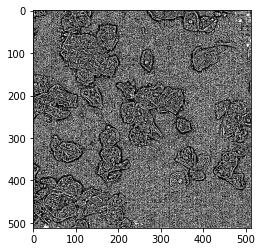

In [163]:
th4 = cv2.adaptiveThreshold(laplacian, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)
plt.imshow(th4, cmap='gray'); plt.show()

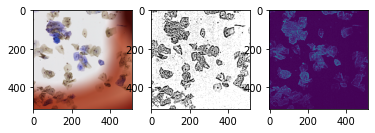

In [151]:
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(th3, cmap='gray')
plt.subplot(133)
plt.imshow(laplacian)
plt.show()

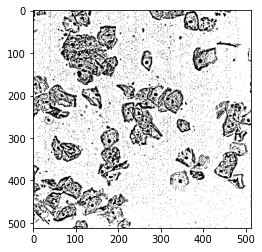

In [146]:
plt.imshow(th3, cmap='gray'); plt.show()

In [171]:
# laplacian
image_size = 512
kernel_size = 32
stride = 24

In [172]:
import numpy as np

def gauss2D(shape=(kernel_size,kernel_size),sigma=2.):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [173]:
gaussian = gauss2D()
gaussian.shape

(32, 32)

torch.Size([21, 21])


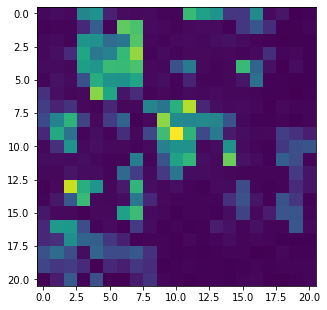

In [174]:

# kernel = torch.ones((1, 1, kernel_size, kernel_size))
kernel = torch.tensor(gaussian).view(1,1,kernel_size, kernel_size).float()

bin_iou = F.conv2d(torch.tensor(laplacian).reshape(1,1,image_size,image_size).float(), 
                    kernel, stride=stride)
bin_iou /= kernel_size * kernel_size
plt.figure(figsize=(5, 10))
# bin_iou_ = bin_iou.squeeze() > 0.15
plt.imshow(bin_iou.squeeze()/torch.max(bin_iou) );
print(bin_iou.squeeze().shape)

In [175]:
# bin_iou.squeeze()/torch.max(bin_iou) 

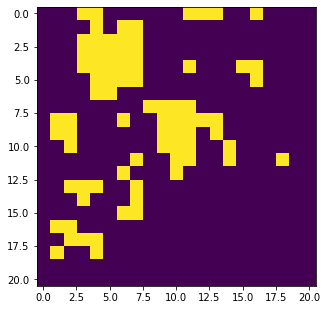

In [176]:
plt.figure(figsize=(5, 10))
# bin_iou_ = bin_iou.squeeze() > 0.15
plt.imshow(bin_iou.squeeze()/torch.max(bin_iou) > 0.3);


(512, 512, 3)


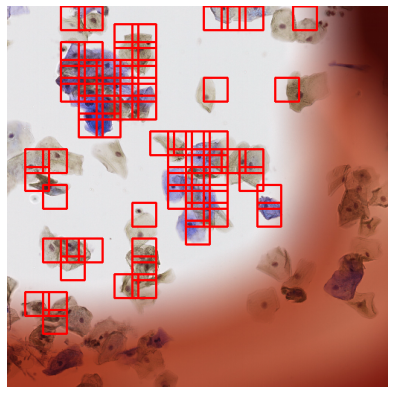

In [180]:
row, col = torch.where(bin_iou.squeeze()/torch.max(bin_iou) > 0.4)
bboxes = []

img = cv2.imread(images_list[IMAGE_NUM])
img = cv2.resize(img, (512,512))

for x, y in zip(col, row) :
#     print(int(x), int(y))
    xmin = int(x) * stride
    xmax = xmin + kernel_size
    ymin = int(y) * stride
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
    
visualize(img, bboxes)    

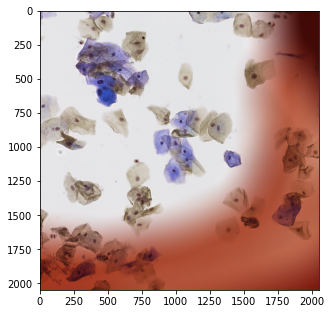

In [117]:

img = cv2.imread(images_list[IMAGE_NUM])
#img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(5, 10))
plt.imshow(img);

(512, 512)


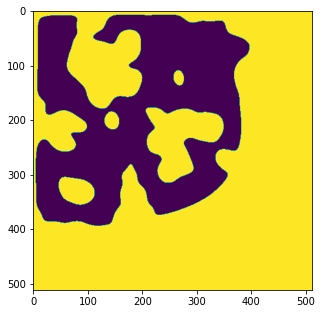

In [57]:
img = cv2.imread(images_list[IMAGE_NUM])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (512,512))
original = np.fft.fft2(img)
center = np.fft.fftshift(original)
LowPassCenter = center * gaussianLP(10,img.shape)
LowPass = np.fft.ifftshift(LowPassCenter)
inverse_LowPass = np.fft.ifft2(LowPass)
LowPass_bin = np.abs(inverse_LowPass) < 200
plt.figure(figsize=(5, 10))
plt.imshow(LowPass_bin);
#plt.imshow(np.abs(inverse_LowPass));
print(inverse_LowPass.shape)

In [9]:
np.abs(inverse_LowPass)

array([[ 89.77027511, 110.42814005, 126.19722205, ...,  35.36661356,
         48.52626967,  67.64078691],
       [101.41565305, 126.85020355, 146.31701322, ...,  34.66092399,
         50.81005689,  74.24476502],
       [109.71679948, 138.57733332, 160.68660868, ...,  34.21181551,
         52.45599519,  78.94761844],
       ...,
       [ 57.20304381,  64.48768063,  69.91381706, ...,  38.06457856,
         42.5647487 ,  49.3223263 ],
       [ 65.15815408,  75.76487936,  83.74750394, ...,  37.14975872,
         43.84595855,  53.7142773 ],
       [ 76.6906943 ,  92.0161366 , 103.65264536, ...,  36.22941615,
         45.98577097,  60.21808956]])

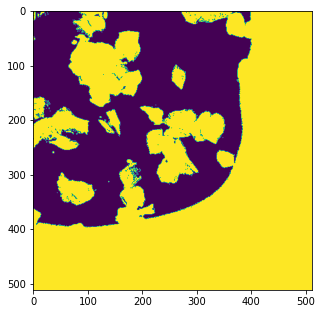

In [52]:
IMAGE_NUM = 2
img = cv2.imread(images_list[IMAGE_NUM])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(img, (512,512))
gray_bin = gray < 200
plt.figure(figsize=(5, 10))
plt.imshow(gray_bin);


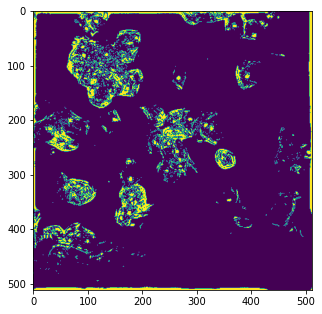

In [61]:
IMAGE_NUM = 2
img = cv2.imread(images_list[IMAGE_NUM])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (512,512))
#img = cv2.medianBlur(img, 5)

original = np.fft.fft2(img)
center = np.fft.fftshift(original)
HighPassCenter = center * gaussianHP(20,img.shape)
HighPass = np.fft.ifftshift(HighPassCenter)
inverse_HighPass = np.fft.ifft2(HighPass)
HighPass_bin = np.abs(inverse_HighPass) > 20
plt.figure(figsize=(5, 10))
plt.imshow(HighPass_bin);

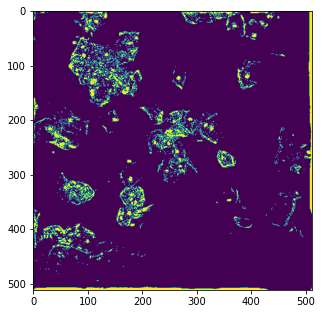

In [63]:

plt.figure(figsize=(5, 10))
#plt.imshow(LowPass_bin & HighPass_bin);
last = gray_bin & HighPass_bin
plt.imshow(last);


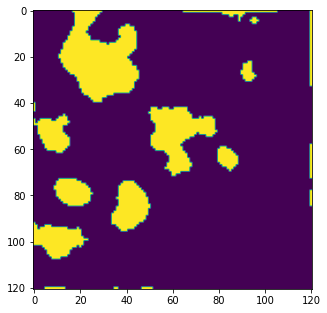

In [71]:
image_size = 512
kernel_size = 32
stride = 4
kernel = torch.ones((1, 1, kernel_size, kernel_size))


bin_iou = F.conv2d(torch.tensor(last).reshape(1,1,image_size,image_size).float(), 
                    kernel, stride=stride)
bin_iou /= kernel_size * kernel_size
plt.figure(figsize=(5, 10))
bin_iou_ = bin_iou.squeeze() > 0.15
plt.imshow(bin_iou_);

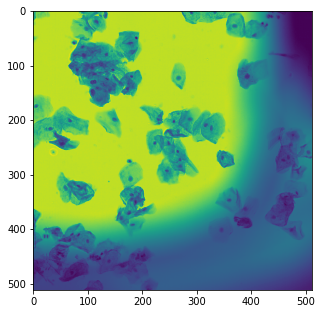

In [46]:
img = cv2.imread(images_list[IMAGE_NUM])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (512,512))
plt.figure(figsize=(5, 10))
plt.imshow(img);